In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

In [6]:
import yfinance as yf

prices = yf.download('AAPL','2014-01-01','2022-12-31')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.388971,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,17.007013,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.099762,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.977467,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,17.084978,258529600


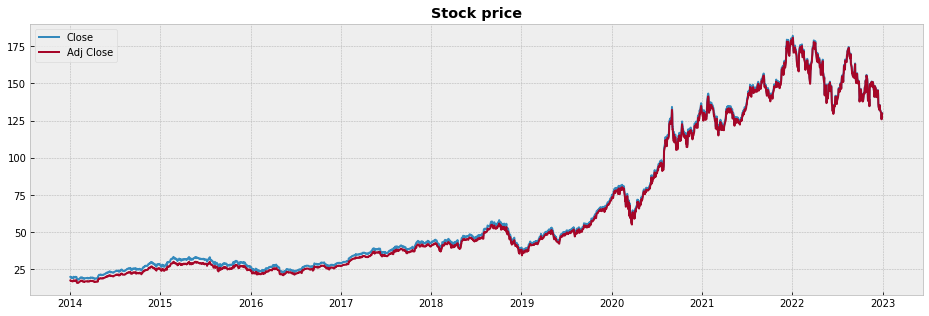

In [7]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

In [8]:
prices.index = prices.index.to_period(freq='d')

price = prices['Adj Close']
ret = price.pct_change()
ret = ret.dropna()

ret

Date
2014-01-03   -0.021966
2014-01-06    0.005454
2014-01-07   -0.007152
2014-01-08    0.006333
2014-01-09   -0.012770
                ...   
2022-12-23   -0.002798
2022-12-27   -0.013878
2022-12-28   -0.030685
2022-12-29    0.028324
2022-12-30    0.002469
Freq: D, Name: Adj Close, Length: 2265, dtype: float64

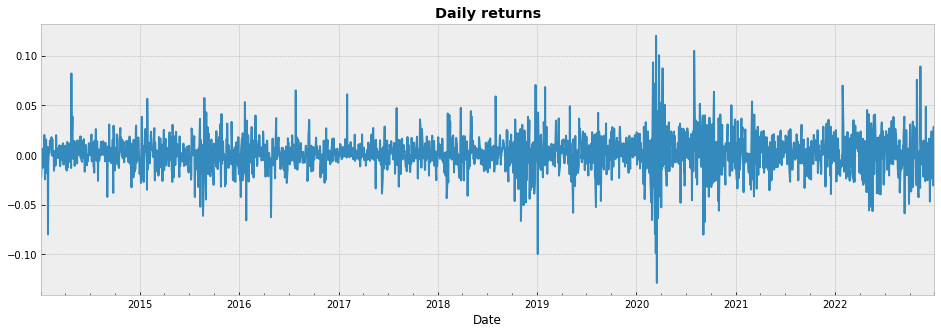

In [9]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

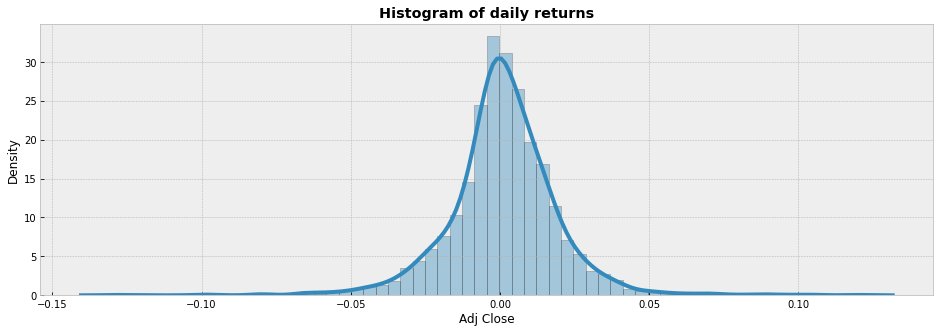

In [11]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True,
             kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

In [124]:
alpha = 0.05

def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index)

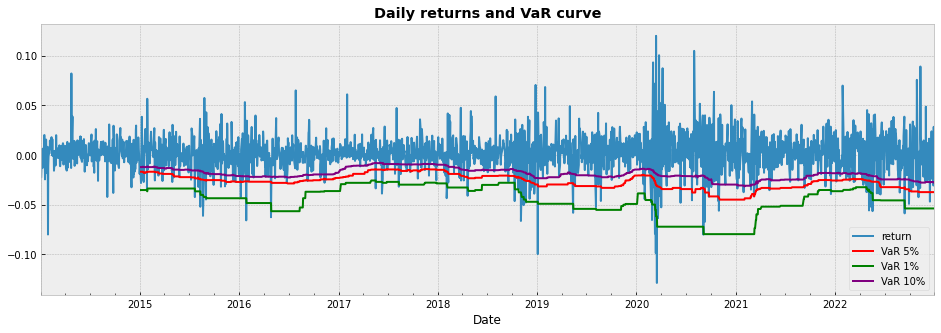

In [26]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=alpha)
VaR_HS_1 = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=0.01)
VaR_HS_10 = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=0.1)

fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot(color='r')
VaR_HS_1.plot(color='g')
VaR_HS_10.plot(color='purple')

plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(['return','VaR 5%','VaR 1%', 'VaR 10%'])

plt.show()

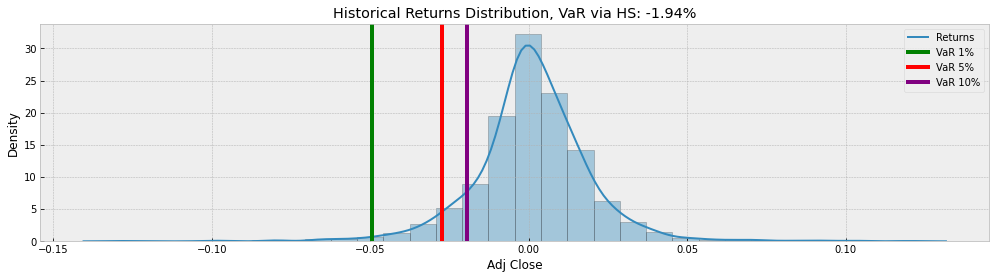

In [221]:
fig = plt.figure(figsize=(17, 4))

VaR_HS_1 = np.quantile(ret, 0.01)
VaR_HS_5 = np.quantile(ret, 0.05)
VaR_HS_10 = np.quantile(ret, 0.10)

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_10))
plt.axvline(x=VaR_HS_1, linewidth=4, color="g")
plt.axvline(x=VaR_HS_5, linewidth=4, color="r")
plt.axvline(x=VaR_HS_10, linewidth=4, color="purple")
plt.legend(['Returns','VaR 1%', 'VaR 5%', 'VaR 10%'])

In [27]:
def get_variance_est(ret, w_est):
    variance_ma = np.full(ret.size, np.nan)

    for i in range(w_est, len(ret)):

        history = ret[i - w_est: i]

        variance_ma[i] = np.sum(np.power(history, 2)) / w_est

    variance_ma = pd.Series(variance_ma, index=ret.index)
    return variance_ma

In [38]:
w_est = 28
variance_ma = get_variance_est(ret, w_est)
variance_ma_x2 = get_variance_est(ret, w_est*2)
variance_ma_d2 = get_variance_est(ret, w_est//2)

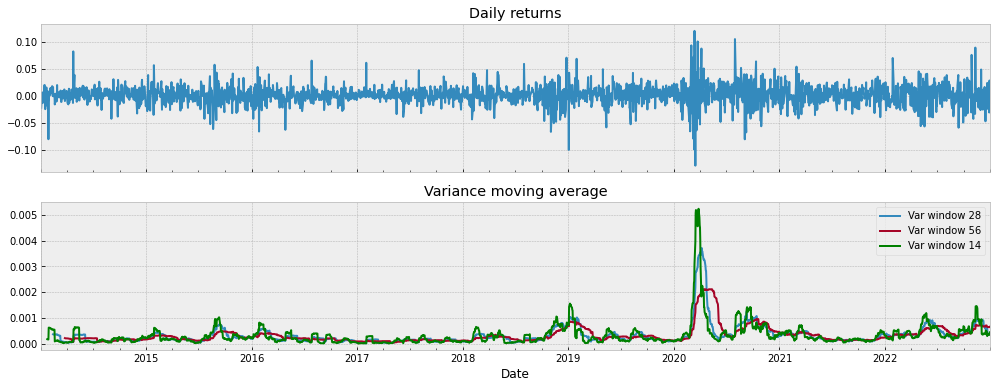

In [42]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

ret.plot(ax=plt1.axes)
plt1.set_title('Daily returns')

variance_ma.plot(ax=plt2.axes)
variance_ma_x2.plot(ax=plt2.axes)
variance_ma_d2.plot(ax=plt2.axes,color='g')
plt2.set_title('Variance moving average')
plt2.legend(['Var window 28', 'Var window 56', 'Var window 14'])

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

# GARCH(1,1) with Constant Mean

In [68]:
from arch import arch_model

am = arch_model(
    100 * ret,
    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal'
                )
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     33,   Neg. LLF: 4391.540977733586
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4362.166025369892
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4362.165955822009
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4362.17
Distribution:                  Normal   AIC:                           8732.33
Method:            Maximum Likelihood   BIC:                           8755.23
                                        No. Observations:                 2265
Date:                Tue, Mar 07 2023   Df Residuals:                     2264
Time:          

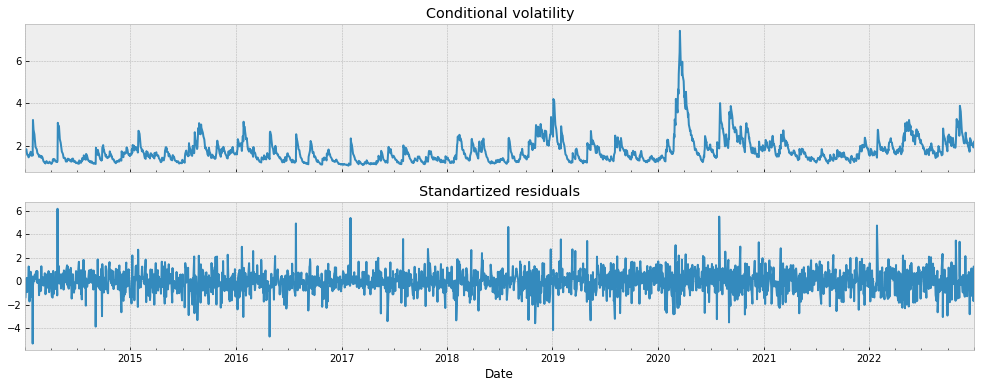

In [69]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standartized residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

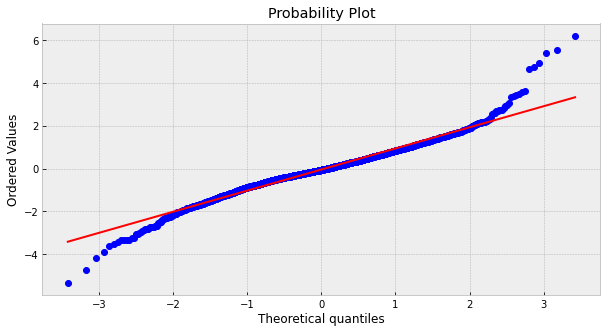

In [75]:
fig = plt.figure(figsize=(10, 5))
ss.probplot((res.resid / res.conditional_volatility).dropna(), dist=am.distribution, plot=plt)
plt.show()

In [181]:
def calculate_VaR_garch(returns, alpha, mean_model,lags=1, dist='Normal'):
    
    model = arch_model(100 * returns,
                    mean=mean_model, lags=lags, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged
    
    res = model.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    
    n_params = model.distribution.num_params
    if n_params == 0:
        q = model.distribution.ppf(alpha)
    else:
        q = model.distribution.ppf(alpha, res.params[-n_params:])

    return_garch_forecast = cond_mean / 100
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / 100

    return VaR_garch_forecast

In [178]:
# calculate_VaR_garch(ret[:50], 0.05, mean_model='Constant', dist='Normal')

In [179]:
from functools import partial

In [183]:
calculate_VaR_garch_const = partial(calculate_VaR_garch, mean_model='Constant',lags=1, dist='Normal')
VaR_garch = calc_VaR(ret, calculate_VaR_garch_const, L_history=252, level=alpha)

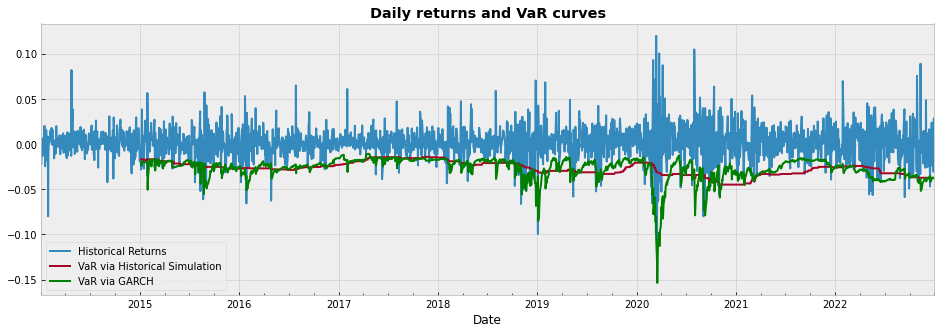

In [168]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot(color='g')

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
#            'VaR via Filtered HS'
           ])

plt.show()

In [171]:
calculate_VaR_garch_harx = partial(calculate_VaR_garch, mean_model='HARX',lags=2, dist='skewedstudent')
VaR_garch = calc_VaR(ret, calculate_VaR_garch_const, L_history=252, level=alpha)

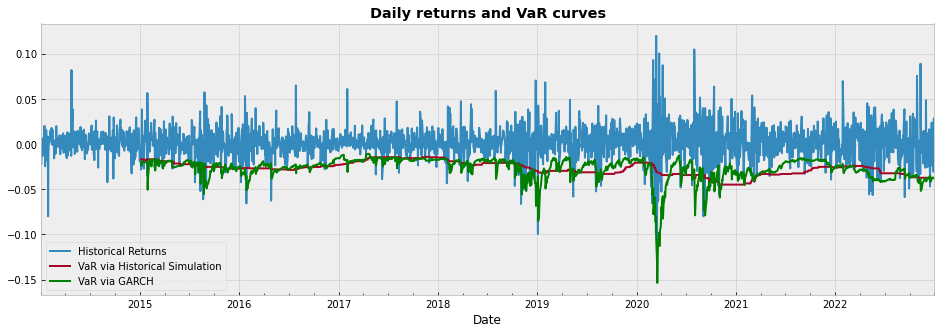

In [172]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot(color='g')

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
#            'VaR via Filtered HS'
           ])

plt.show()

In [202]:
from arch import arch_model

am = arch_model(
    100 * ret,
    mean='HARX', lags=3, # mean = Constant, ARX, HARX + the number of lags
    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent'
                )
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     63,   Neg. LLF: 10912.942965649596
Iteration:     10,   Func. Count:    119,   Neg. LLF: 5727.130684198335
Iteration:     15,   Func. Count:    175,   Neg. LLF: 4244.472192670424
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4244.2991886480395
            Iterations: 18
            Function evaluations: 205
            Gradient evaluations: 18
                                HAR - GARCH Model Results                                
Dep. Variable:                         Adj Close   R-squared:                       0.001
Mean Model:                                  HAR   Adj. R-squared:                 -0.000
Vol Model:                                 GARCH   Log-Likelihood:               -4244.30
Distribution:      Standardized Skew Student's t   AIC:                           8506.60
Method:                       Maximum Likelihood   BIC:                           8558.11
                                

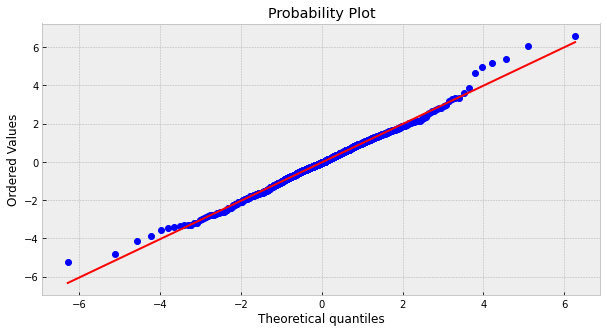

In [203]:
fig = plt.figure(figsize=(10, 5))
ss.probplot((res.resid / res.conditional_volatility).dropna(), dist=am.distribution, sparams=(res.params[-2:],), plot=plt)
plt.show()